# RGB сlassification with TensorFlow Lite for ESP32
### Подготовил: Степанюк Денис Борисович
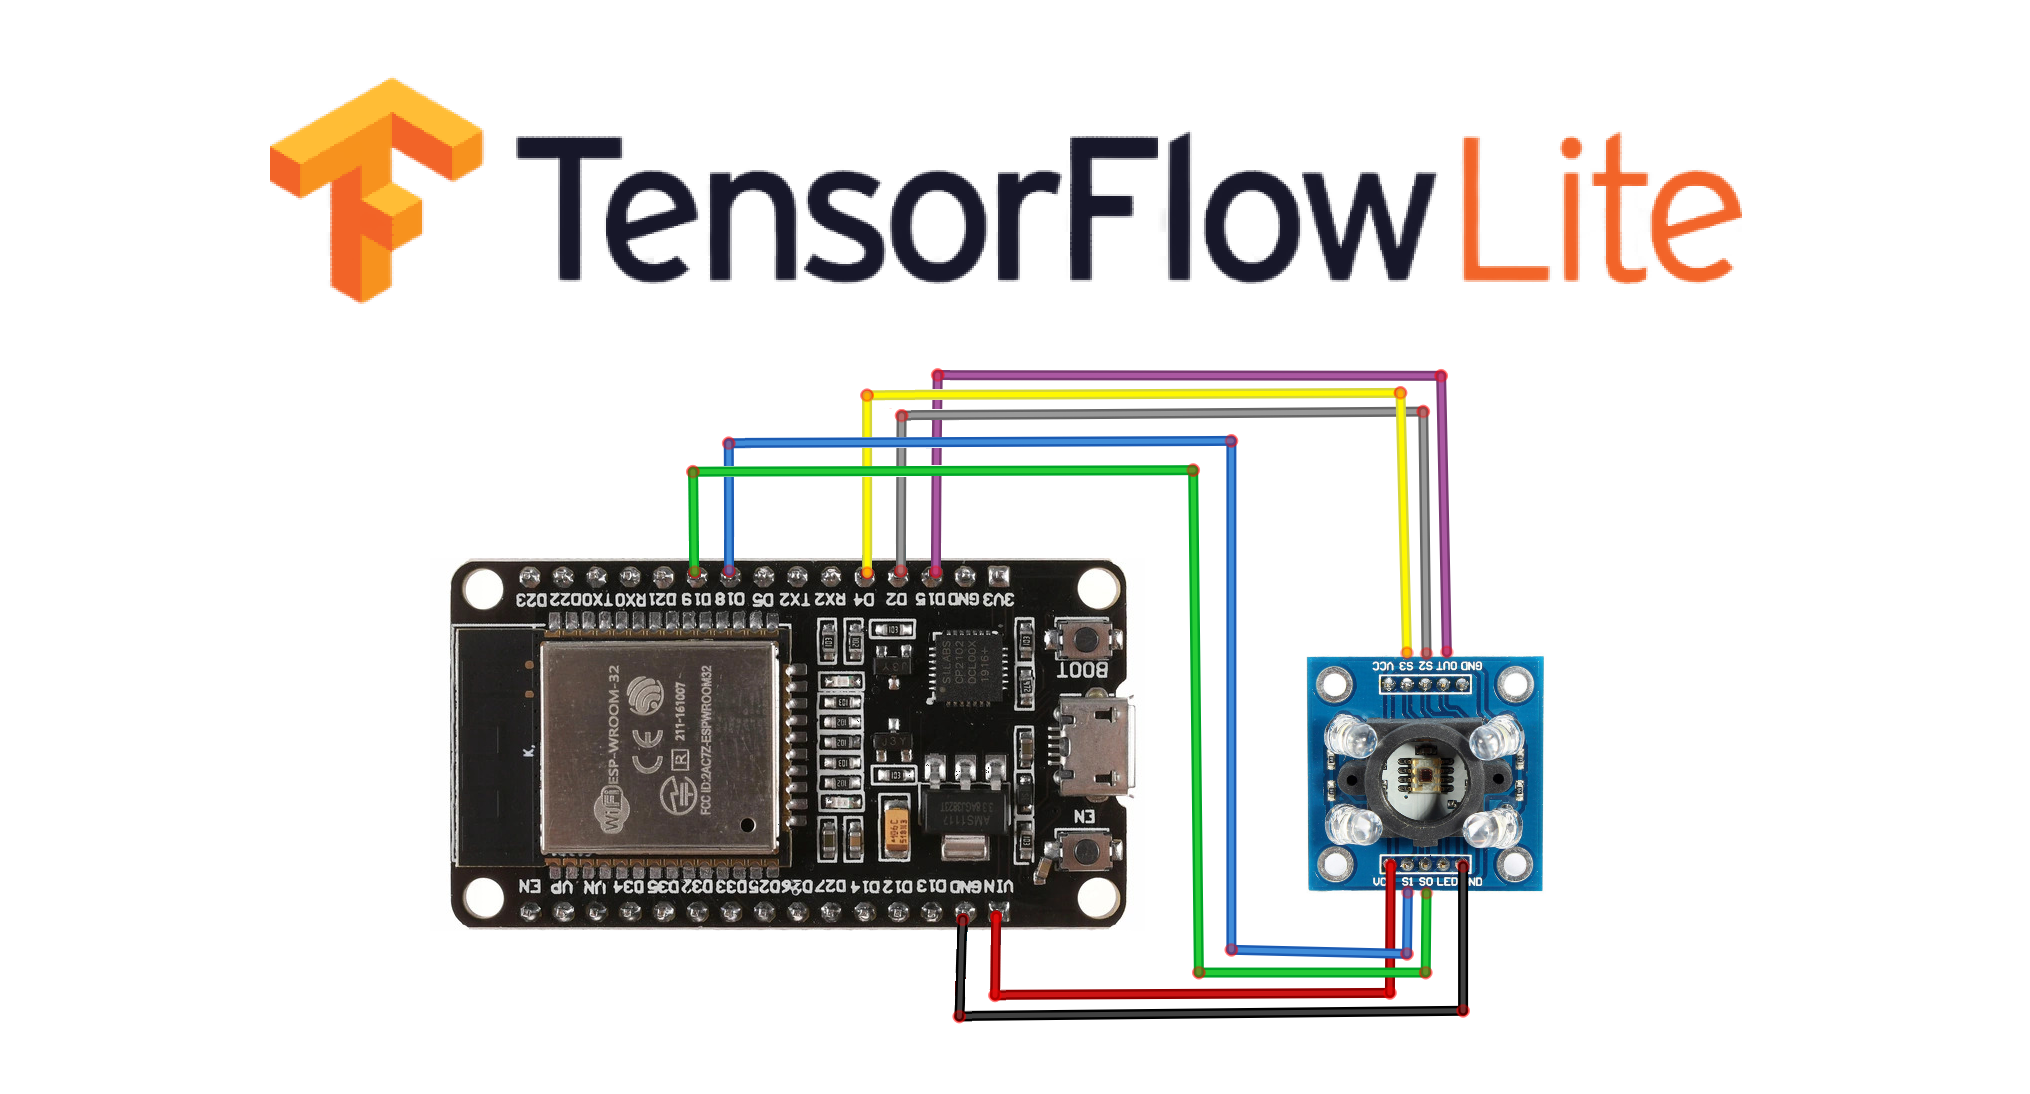

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Числовые признаки.
num_cols = [
    'RED',
    ' GREEN',
    ' BLUE',
    ' WHITE'
]

# Предсказываемый категориальный признак.
target_col = ' COLOR'

# Загрузим данные.
data = pd.read_csv('./DATASET_ESP32.txt')

# Посмотрим на 'n' случайных строчек
data.sample (n = 10)

RED   GREEN   BLUE   WHITE    COLOR   0 
56   14      24     14       5   Purple   57
0    10      28     21       6      Red    1
32   18      16     20       6    Green   33
72   55      58     48      17    Black   73
74   58      61     50      17    Black   75
43   23      15     11       4     Blue   44
54   15      26     14       5   Purple   55
14    8      15     17       4   Orange   15
61    8       8      7       2    White   62
49   24      15     11       4     Blue   50

## 3D график

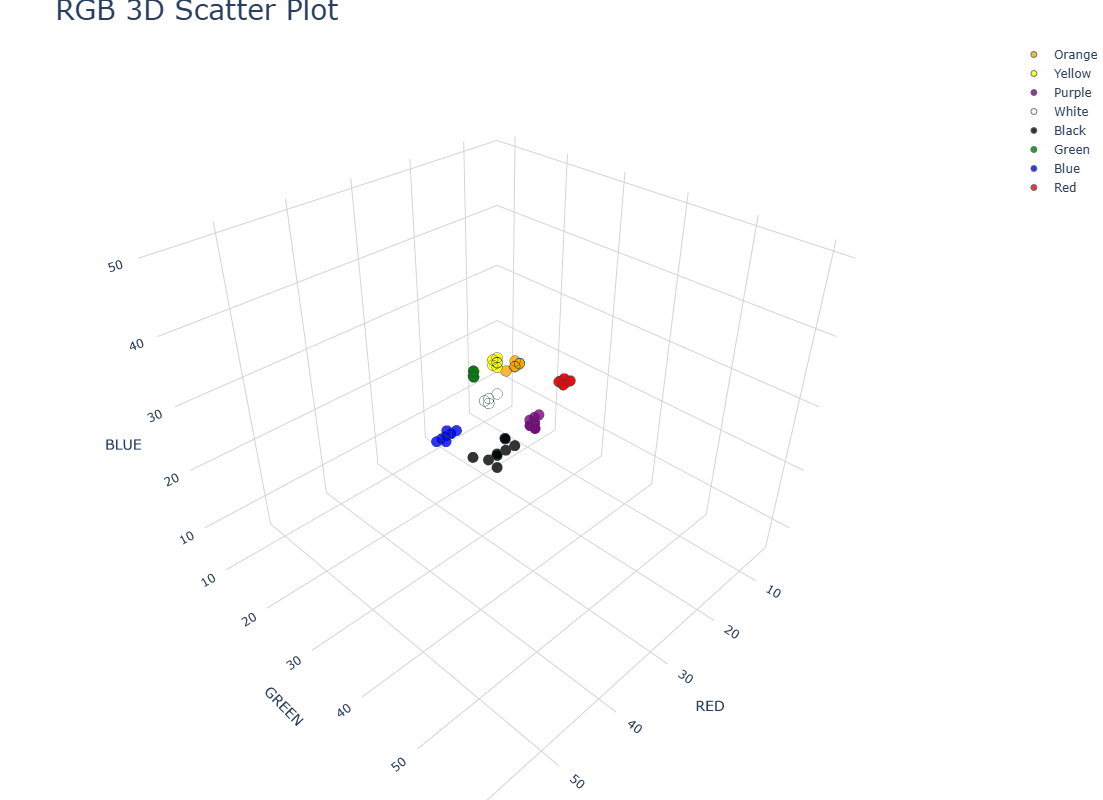

In [3]:
import plotly.graph_objects as go

colors = data[' COLOR'].str.strip()
fig = go.Figure()

color_map = {
    'Orange': 'orange',
    'Yellow': 'yellow',
    'Purple': 'purple',
    'White': 'white',
    'Black': 'black',
    'Green': 'green',
    'Blue': 'blue',
    'Red': 'red'
}

for color_name, plot_color in color_map.items():
    mask = colors == color_name
    fig.add_trace(go.Scatter3d(
        x=data.loc[mask, 'RED'],
        y=data.loc[mask, ' GREEN'],
        z=data.loc[mask, ' BLUE'],
        mode='markers',
        marker=dict(
            size=6,                # Сделать точки больше
            color=plot_color,
            opacity=0.8,            # Немного прозрачные
            line=dict(width=1, color='DarkSlateGrey')  # Обводка у точек
        ),
        name=color_name
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='RED',
        yaxis_title='GREEN',
        zaxis_title='BLUE',
        xaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        yaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
        zaxis=dict(backgroundcolor="white", gridcolor="lightgrey", showbackground=True),
    ),
    title=dict(text='RGB 3D Scatter Plot', font=dict(size=28)),
    width=1000,  # Больше ширина
    height=800,  # Больше высота
    margin=dict(l=0, r=0, b=0, t=40),  # Меньше отступы
    template='plotly_white'  # Светлая красивая тема
)

fig.show()

# Подготовка данных
### Признаки подаваемые на вход модели

In [4]:
# Признаки на которых будем обучать модель предсказывать цвет.
X_data = data[num_cols]
X_data.head(n=5)

RED   GREEN   BLUE   WHITE
0   10      28     21       6
1   10      28     21       5
2   10      26     20       5
3   11      27     21       6
4   11      29     22       6

### Масштабирование данных

Стандартизируем признаки, удалив из признака среднее значение $\mu_i$ и разделив на стандартное отклонение $\sigma_i$.

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$

**$\mu_i$ - среднее значение (***std_scaler.mean_***)**

$$\mu_i = \frac{1}{n} \sum_{j=1}^{n} x_{ij}$$

➊ $x_{ij}$ — значение признака i у объекта j

➋ $n$ — количество объектов

**$\sigma_i$ - стандартное отклонение (***std_scaler.scale_***)**

$$\sigma_i = \sqrt{\frac{1}{n - 1} \sum_{j=1}^{n} (x_{ij} - \mu_i)^2}$$

➊ $x_{ij}$ — значение признака i у объекта j

➋ $\mu_i$ — среднее значение признака i

➌ $n$ — количество объектов

In [5]:
from sklearn.preprocessing import StandardScaler

# Экземпляр обьекта для масштабирования данных.
std_scaler = StandardScaler()

# Расчитаем стандартное отклонение и среднее значение для всех признаков всего датасета.
std_scaler.fit(X_data.values)
std_scaler_mean = std_scaler.mean_
print(f'Среднее значение для признаков: {std_scaler_mean}')
std_scaler_scale = std_scaler.scale_
print(f'Стандартное отклонение для признаков: {std_scaler_scale}')

# Отмасштабированный датасет.
X_data_scaled = std_scaler.transform(X_data.values)

Среднее значение для признаков: [17.7875 21.775  19.1375  5.7875]
Стандартное отклонение для признаков: [14.87001492 14.88705394 11.70335823  4.21216616]


### Отмасштабированные признаки на которых будем обучать модель предсказывать цвет.

In [6]:
# FLOAT:
X_data_scaled_float = {'RED': X_data_scaled[:,0], 'GREEN': X_data_scaled[:,1], 'BLUE': X_data_scaled[:,2], 'WHITE': X_data_scaled[:,3]}
X_data_scaled_float = pd.DataFrame(data=X_data_scaled_float)
X_data_scaled_float.head(n=5)

RED     GREEN      BLUE     WHITE
0 -0.523705  0.418149  0.159142  0.050449
1 -0.523705  0.418149  0.159142 -0.186958
2 -0.523705  0.283804  0.073697 -0.186958
3 -0.456455  0.350976  0.159142  0.050449
4 -0.456455  0.485321  0.244588  0.050449

In [7]:
# INT8:
X_data_scaled_int8 = {'RED': np.int8(X_data_scaled[:,0]*127.5), 'GREEN': np.int8(X_data_scaled[:,1]*127.5),
                 'BLUE': np.int8(X_data_scaled[:,2]*127.5), 'WHITE': np.int8(X_data_scaled[:,3]*127.5)}
X_data_scaled_int8 = pd.DataFrame(data=X_data_scaled_int8)
X_data_scaled_int8.head(n=5)

RED  GREEN  BLUE  WHITE
0  -66     53    20      6
1  -66     53    20    -23
2  -66     36     9    -23
3  -58     44    20      6
4  -58     61    31      6

### Категориальные бинарные вектора

In [8]:
# Преобразуем категориальные текстовые метки (правильные ответы) цвета в бинарные вектора.
Y_data_cat = pd.get_dummies(data[target_col])
# Кол-во предсказываемых категориальные меток.
cat_num = Y_data_cat.shape[1]
Y_data_cat.head(n=5)
#Y_data_cat.sample(n=5)

Black   Blue   Green   Orange   Purple   Red   White   Yellow
0   False  False   False    False    False  True   False    False
1   False  False   False    False    False  True   False    False
2   False  False   False    False    False  True   False    False
3   False  False   False    False    False  True   False    False
4   False  False   False    False    False  True   False    False

In [9]:
colorsArrayESP32 = 'const char* kCategoryLabels[' + str(cat_num) + '] = {'
for i in range(cat_num):
    colorsArrayESP32 += '"' + Y_data_cat.columns[i][1:] + '", '
colorsArrayESP32 = colorsArrayESP32[:-2] + '};'

colorsArrayESP32

'const char* kCategoryLabels[8] = {"Black", "Blue", "Green", "Orange", "Purple", "Red", "White", "Yellow"};'

In [10]:
from sklearn.model_selection import train_test_split

# Разделим датасет на две части (тренировочную и тестовую).
X_train, X_test, Y_train, Y_test = train_test_split(X_data_scaled_int8.values, Y_data_cat.values, train_size = 0.75)

# TensorFlow Lite
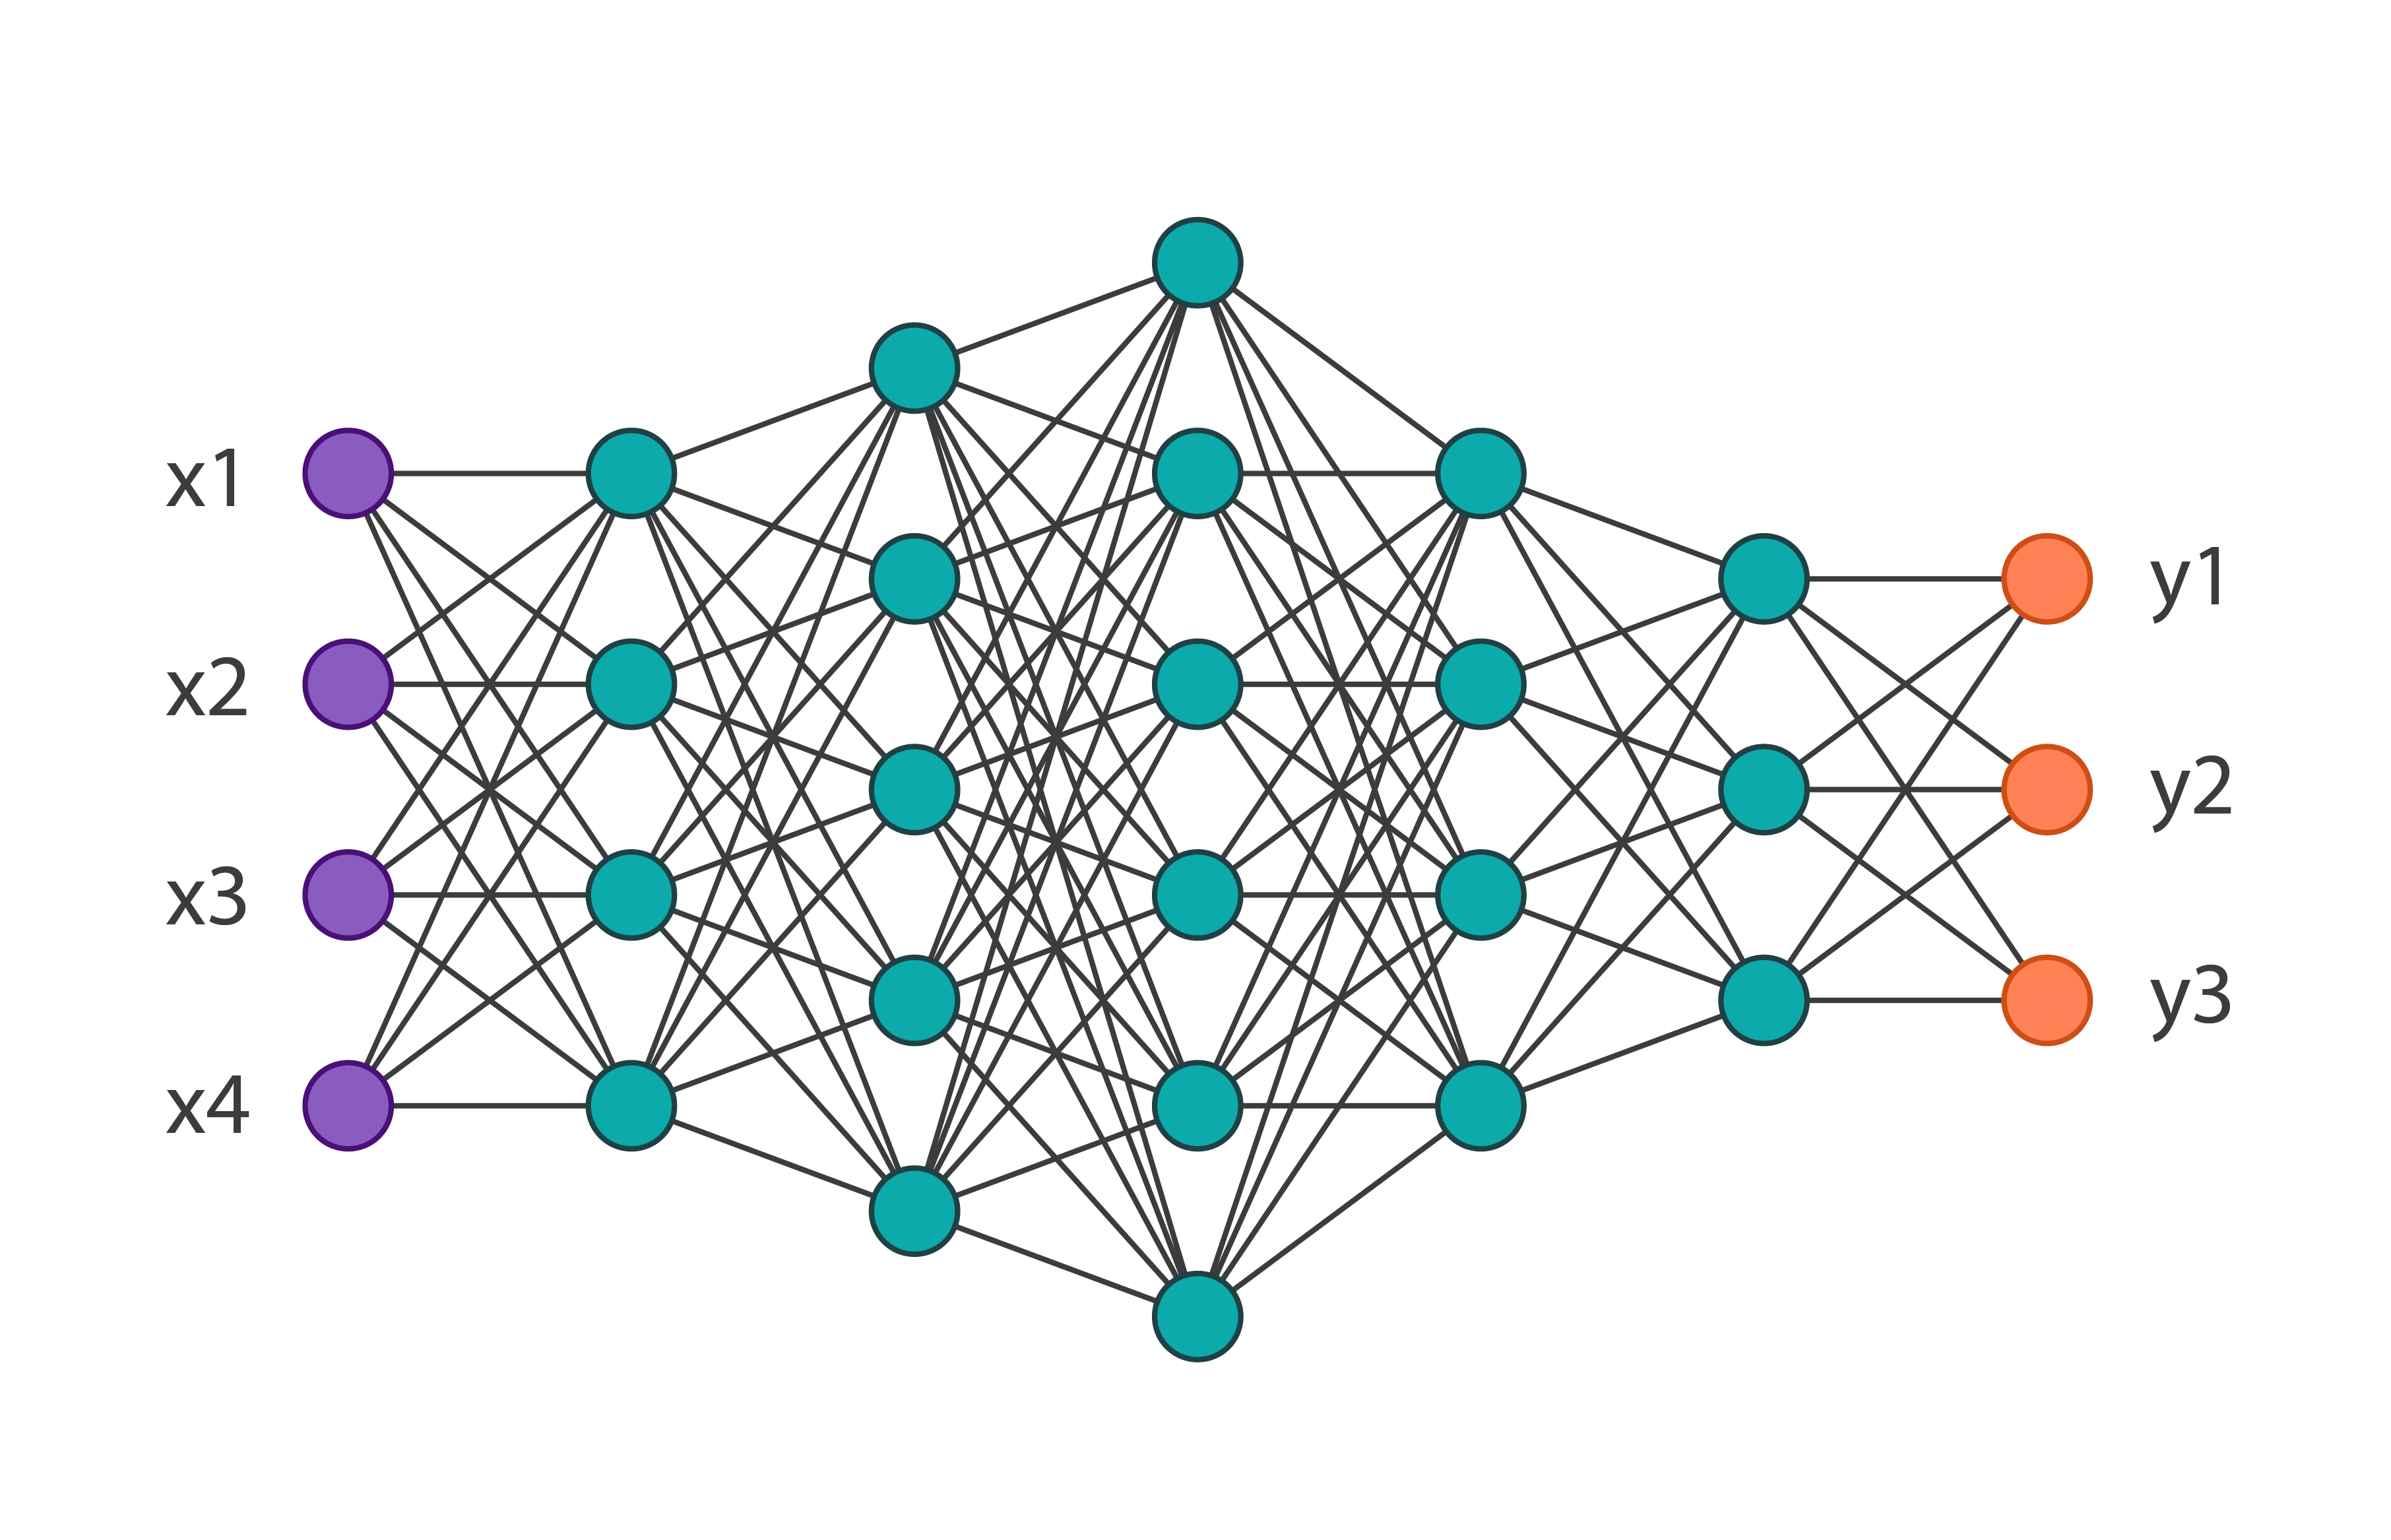

## Модель

In [11]:
# Библиотека для создания и обучения моделей глубокого обучения.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

In [12]:
# Определим объект для динамической настройки скорости обучения (learning rate) во время тренировки модели.
    # monitor: параметр указывает, какую метрику следует отслеживать для принятия решения о снижении скорости обучения.
    # patience = 2: Если в течение двух эпох не будет улучшений, скорость обучения будет уменьшена.
    # verbose = 1: Если установлен в 1, то в консоль будут выводиться сообщения о снижении скорости обучения.
    # factor=0.25: Это коэффициент, на который будет умешаться текущая скорость обучения, если не наблюдается улучшения.
    # min_lr: Это минимально допустимое значение для скорости обучения.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 8, verbose=1, factor=0.5, min_lr=0.000001)

In [13]:
# Инициализация модели.
model = Sequential()

# 1-й полносвязный слой.
model.add(Dense(units = 64, activation = 'relu', input_shape=(4, )))
# Отключить 5% случайных нейронов в слое во время обучения. 
#model.add(Dropout(0.05))

# 2-й полносвязный слой.
model.add(Dense(units = 128, activation = 'relu'))
# Отключить 5% случайных нейронов в слое во время обучения. 
#model.add(Dropout(0.05))

# 3-й полносвязный слой (выход модели).
model.add(Dense(units = cat_num, activation = 'softmax'))

# Собрать модель.
    # optimizer: оптимизатор, который будет использоваться для обновления весов модели во время обучения.
    # loss: функция потерь, которая будет использоваться для оценки качества предсказаний модели. 
    # metrics: метрика, которая будет отслеживаться во время обучения и валидации чтобы понять, насколько хорошо модель работает на данных.
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# Вывод текстового представления структуры модели нейронной сети. 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 9672 (37.78 KB)
Trainable params: 9672 (37.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Обучение модели

In [14]:
# Кол-во итераций обучения.
Epochs = 20

# Запустить обучение модели.
history = model.fit(x = X_train, # Признаки на которых будем предсказывать цвет.
                    y = Y_train, # Правильные ответы.
                    epochs = Epochs, # Кол-во итераций обучения.
                    validation_data = (X_test, Y_test), # Валидационные данные.
                    callbacks = [learning_rate_reduction])

# Сохранить модель.
model.save('model.h5')

Epoch 1/20
2/2 [==============================] - 0s 104ms/step - loss: 10.5670 - accuracy: 0.2000 - val_loss: 9.4365 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 5.3425 - accuracy: 0.3833 - val_loss: 4.8913 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 0s 16ms/step - loss: 2.8056 - accuracy: 0.5833 - val_loss: 2.0660 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 0s 17ms/step - loss: 1.1216 - accuracy: 0.7000 - val_loss: 0.3642 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 0s 17ms/step - loss: 0.2874 - accuracy: 0.9000 - val_loss: 0.2134 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 0s 17ms/step - loss: 0.1587 - accuracy: 0.9500 - val_loss: 0.0782 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/20
2/2 [==============================] - 0s 16ms/step - loss: 0.0810 - accura

C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [15]:
# Оценим качество обученой модели сравнив предсказания с правильными ответами.
print("Accuracy of the model is - " , model.evaluate(X_test, Y_test)[1]*100 , "%")

1/1 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


## Анализ процесса обучения модели

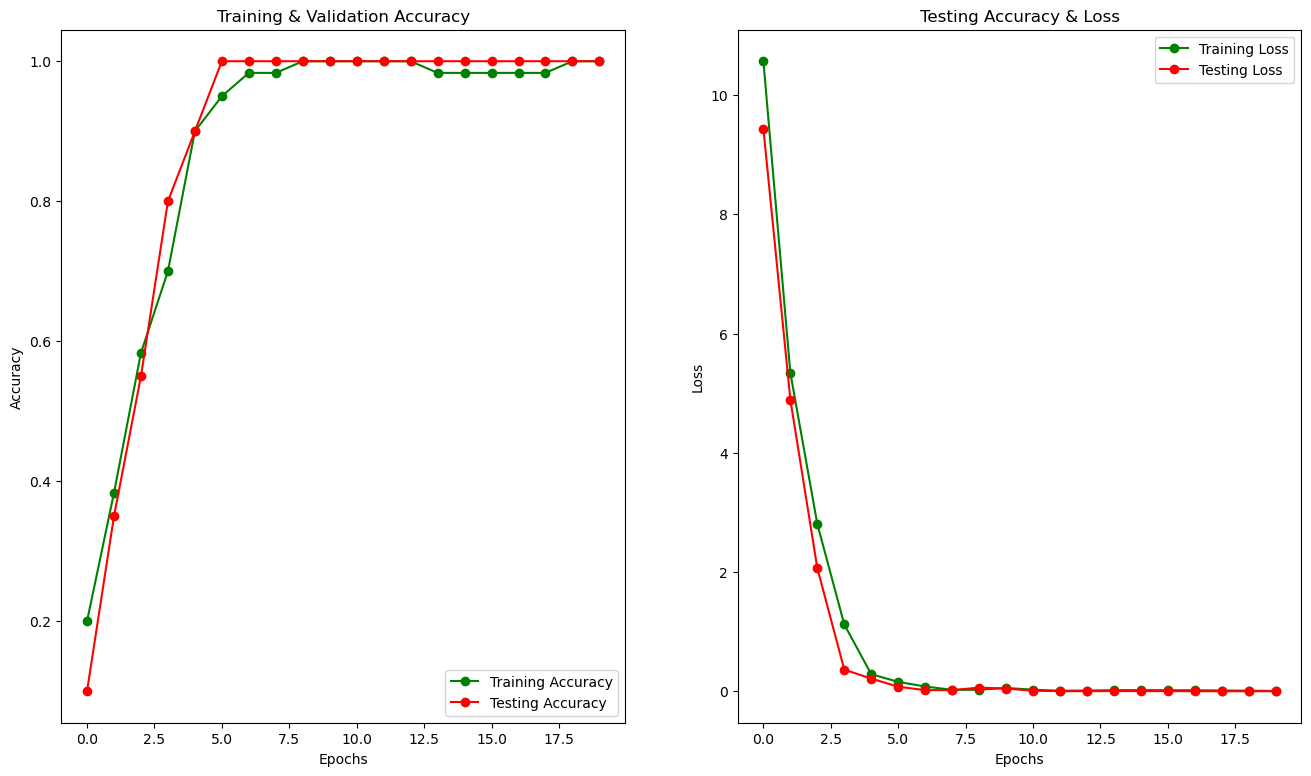

In [16]:
epochs = [i for i in range(Epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

## Конвертируем модель в облегчённый формат

### Подготавливаем репрезентативную выборку

In [17]:
def representative_dataset():
    for i in range(len(X_train)):
        # Оборачиваем каждую строку в batch размером (1, 4)
        data = np.expand_dims(X_train[i], axis=0).astype(np.float32)
        yield [data]

### Конвертируем модель

In [18]:
# Платформа для машинного обучения, разработанная Google, которая предоставляет инструменты для создания, 
# обучения и развертывания моделей машинного и глубокого обучения
import tensorflow as tf

# Передаём модель в конвертер.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Передаём репрезентативную выборку в конвертер.
converter.representative_dataset = representative_dataset

# Указываем оптимизатор для модели.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Передаём набор встроенных операций, которые поддерживают 8-битные целочисленные (от -128 до 127) вычисления. 
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Указываем что вход модели отныне принимает 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_input_type = tf.int8
# Указываем что выход модели отныне выдаёт 8-битный целочисленный тип данных (от -128 до 127).
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmp713966z5\assets


INFO:tensorflow:Assets written to: C:\Users\STEPAN~1\AppData\Local\Temp\tmp713966z5\assets
C:\Users\STEPANJUK\.conda\envs\STEP1\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning:

Statistics for quantized inputs were expected, but not specified; continuing anyway.



In [19]:
# Сохранить облегчённую модель.
open("model.tflite", "wb").write(tflite_model)

12760

##### Команда для текстового редактора "vim" чтобы преобразовать бинарный файл в C/C++ формат, который можно использовать как массив байтов в исходном коде для ESP32.

#### xxd -i model.tflite > model.cc

## Оценим качество облегчённой модели

In [20]:
# Путь к сохранённой облегчённой модели.
tflite_model_path = "model.tflite"

# Загрузка модели и выделение памяти под тензоры.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Получить входной и выходной тензоры.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Параметры для масштабирования 
input_scale, input_zero_point = input_details[0]['quantization']

# Вывести размеры входного и выходного тензора.
input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[1 4]
[1 8]


In [21]:
input_scale, input_zero_point = input_details[0]['quantization']
print(input_scale)
print(input_zero_point)

0.9450980424880981
-4


In [22]:
# Список для всех предсказаний.
predictions = []

# Предскажем классы для всей тестовой выборки.
for i in range(X_test.shape[0]):
    # Передаём данные.
    #interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_test[i]-127.5, axis=0).astype(np.int8))
    #interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_test[i]*127.5, axis=0).astype(np.int8))
    #interpreter.set_tensor(input_details[0]['index'], np.expand_dims(np.int8(X_test[i]*127.5), axis=0))
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(np.int8(X_test[i]), axis=0))
    interpreter.invoke()
    # Получаем результат.
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    # Сохраним предсказания.
    predictions.append(tflite_model_predictions[0])
    
    print("Prediction ", i, ": ", tflite_model_predictions[0])
    print("predicted_class:",np.argmax(tflite_model_predictions, axis=1)[0])
    print("correct_class:",np.argmax(Y_test[i]))
    print("------------------------------------")

Prediction  0 :  [ 127 -128 -128 -128 -128 -128 -128 -128]
predicted_class: 0
correct_class: 0
------------------------------------
Prediction  1 :  [-128 -128 -128  126 -128 -128 -128 -127]
predicted_class: 3
correct_class: 3
------------------------------------
Prediction  2 :  [-128 -128 -128  127 -128 -128 -128 -128]
predicted_class: 3
correct_class: 3
------------------------------------
Prediction  3 :  [-128 -128 -128 -128  127 -127 -128 -128]
predicted_class: 4
correct_class: 4
------------------------------------
Prediction  4 :  [-128 -128 -128 -128 -128  127 -128 -128]
predicted_class: 5
correct_class: 5
------------------------------------
Prediction  5 :  [-128 -128 -128 -128  127 -127 -128 -128]
predicted_class: 4
correct_class: 4
------------------------------------
Prediction  6 :  [-128 -128 -128 -120 -128 -128 -128  120]
predicted_class: 7
correct_class: 7
------------------------------------
Prediction  7 :  [-128 -128 -128 -124 -128 -128 -128  124]
predicted_class: 

In [23]:
# Оценим качество облегчённой модели сравнив предсказания с правильными ответами.
from sklearn.metrics import accuracy_score
acc = accuracy_score(np.argmax(predictions, axis=1), np.argmax(Y_test, axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 1.0


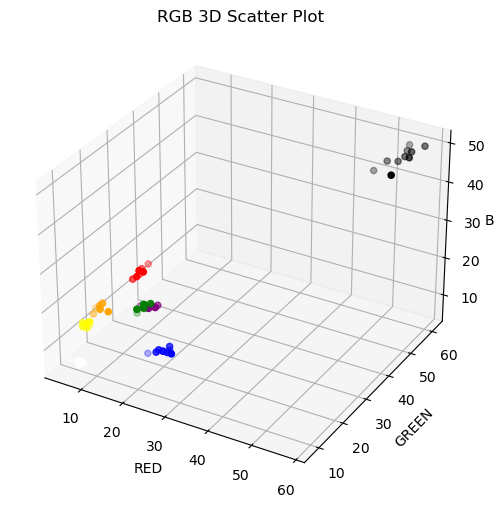

In [24]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

# Координаты для осей (RGB компоненты).
X_r = data[['RED', ' COLOR']]
Y_g = data[[' GREEN', ' COLOR']]
Z_b = data[[' BLUE', ' COLOR']]

# Создать фигуру и 3D-ось.
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Создать диаграмму рассеяния.
ax.scatter(X_r[X_r[' COLOR']==' Orange']['RED'], Y_g[Y_g[' COLOR']==' Orange'][' GREEN'], Z_b[Z_b[' COLOR']==' Orange'][' BLUE'], color='orange')
ax.scatter(X_r[X_r[' COLOR']==' Yellow']['RED'], Y_g[Y_g[' COLOR']==' Yellow'][' GREEN'], Z_b[Z_b[' COLOR']==' Yellow'][' BLUE'], color='yellow')
ax.scatter(X_r[X_r[' COLOR']==' Purple']['RED'], Y_g[Y_g[' COLOR']==' Purple'][' GREEN'], Z_b[Z_b[' COLOR']==' Purple'][' BLUE'], color='purple')
ax.scatter(X_r[X_r[' COLOR']==' White']['RED'], Y_g[Y_g[' COLOR']==' White'][' GREEN'], Z_b[Z_b[' COLOR']==' White'][' BLUE'], color='white')
ax.scatter(X_r[X_r[' COLOR']==' Black']['RED'], Y_g[Y_g[' COLOR']==' Black'][' GREEN'], Z_b[Z_b[' COLOR']==' Black'][' BLUE'], color='black')
ax.scatter(X_r[X_r[' COLOR']==' Green']['RED'], Y_g[Y_g[' COLOR']==' Green'][' GREEN'], Z_b[Z_b[' COLOR']==' Green'][' BLUE'], color='green')
ax.scatter(X_r[X_r[' COLOR']==' Blue']['RED'], Y_g[Y_g[' COLOR']==' Blue'][' GREEN'], Z_b[Z_b[' COLOR']==' Blue'][' BLUE'], color='blue')
ax.scatter(X_r[X_r[' COLOR']==' Red']['RED'], Y_g[Y_g[' COLOR']==' Red'][' GREEN'], Z_b[Z_b[' COLOR']==' Red'][' BLUE'], color='red')

# Метки.
ax.set_xlabel('RED')
ax.set_ylabel('GREEN')
ax.set_zlabel('BLUE')
ax.set_title('RGB 3D Scatter Plot')

plt.show()